# Import library

In [2]:
import pandas as pd 
import numpy as np
import os
import math
import pathlib
import matplotlib.pyplot as plt 
import seaborn as sns

# Import data

In [3]:
import os
import pandas as pd

root = r"C:\Users\lenovo\nhatquang\project\ads_enfit\data"

# Define important columns
data_cols = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id','prediction_unit_id']
client_cols = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_prices_cols = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh','origin_date','data_block_id']
electricity_prices_cols = ['forecast_date', 'euros_per_mwh','origin_date','data_block_id']
forecast_weather_cols = ['latitude', 'longitude', 'hours_ahead', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
historical_weather_cols = ['datetime', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure','cloudcover_total','cloudcover_low','cloudcover_mid','cloudcover_high','windspeed_10m','winddirection_10m','shortwave_radiation','direct_solar_radiation','diffuse_radiation','latitude','longitude']
location_cols = ['longitude', 'latitude', 'county']
target_cols = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime']

# Importing only specified columns
df_train = pd.read_csv(os.path.join(root, "train.csv"), usecols=data_cols)
df_client = pd.read_csv(os.path.join(root, "client.csv"), usecols=client_cols)
df_gas_prices = pd.read_csv(os.path.join(root, "gas_prices.csv"), usecols=gas_prices_cols)
df_electricity_prices = pd.read_csv(os.path.join(root, "electricity_prices.csv"), usecols=electricity_prices_cols)
df_forecast_weather = pd.read_csv(os.path.join(root, "forecast_weather.csv"), usecols=forecast_weather_cols, parse_dates=True)
df_historical_weather = pd.read_csv(os.path.join(root, "historical_weather.csv"), usecols=historical_weather_cols, parse_dates=True)
df_weather_station_to_county_mapping = pd.read_csv(os.path.join(root, "weather_station_to_county_mapping.csv"), usecols=location_cols, parse_dates=True)

# Select target columns from df_data
df_target = df_train[target_cols]


## EDA the `train.csv` file

- `county`: ID của hạt.

> Bao nhiêu hạt? Mỗi hạt khác nhau có khác biệt như thế nào? 

- `product_type`: ID của loại hợp đồng, có 4 loại:

    - 0: Combined (Loại hợp đồng kết hợp)
    - 1: Fixed (Loại hợp đồng cố định)
    - 2: General service (Loại hợp đồng dịch vụ)
    - 3: Spot (Loại hợp đồng giao ngay)

> Ý nghĩa của từng loại hợp đồng này là gì? Các thông số khác có ảnh hưởng đến các loại hợp đồng này hay không? Các hợp đồng này có ảnh hưởng đến các chỉ số khác hay không (Cố tìm ra đặc điểm chung)? 

- `target`: Lượng năng lượng tiêu thụ hoặc sản xuất cho phân khúc của mỗi giờ. (Phân khúc được xác định bởi `county`, `is_business` và `product_type`).

> Như vậy có thể thấy rằng `target` chịu ảnh hưởng bởi 3 biến `county`, `is_business` và `product_type`

- `is_consumption`: Giá trị True/False cho biết rằng target có phải là người tiêu dùng hay là người sản xuất. 

> Các đối tượng này khác nhau ở điểm nào? Đề xuất giả thuyết, EDA để chứng minh các giả thuyết được đề ra

- `datetime`: Theo khung giờ Estonian EET (UTC+2)/EEST (UTC+3). Mô tả chu kỳ 1 tiếng từ lúc target được cho. 

> Chưa nghĩ ra

- `data_block_id`: Tất cả các hàng cùng chia sẻ `data_block_id` giống nhau sẽ có sẵn cùng một thời gian dự báo. Đây là một hàm của thông tin có sẵn khi dự báo thực sự được thực hiện, vào lúc 11 giờ sáng mỗi ngày. Ví dụ, nếu data_block_id dự báo thời tiết cho các dự đoán được thực hiện vào ngày 31 tháng 10 là 100 thì data_block_id thời tiết lịch sử cho ngày 31 tháng 10 sẽ là 101 vì dữ liệu thời tiết lịch sử chỉ thực sự có sẵn vào ngày hôm sau.

> Chưa nghĩ ra

- `row_id`: Số định danh của mỗi row riêng biệt

> Chưa nghĩ ra

- `prediction_unit_id`: Định danh riêng cho mỗi `county`, `is_business` và `product_type`, nói cụ thể hơn thì giá trị này là sự kết hợp của cả 3 .


Đầu tiên là overview cho tập train trước

In [4]:
df_train.head()

,county,is_business,product_type,target,is_consumption,datetime,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,4,2


Dựa vào thông tin có trong dataframe này, các `prediction_unit_id` riêng biệt là thể hiện riêng cho 1 công ty, nhớ lại rằng **một prosumer có thể vừa là bên sản xuất, vừa là bên tiêu thụ**, do đó để tổng quan, ứng với mỗi 1 prosumer sẽ có 1 bộ `[0,1]` khác nhau, để đề phòng cho việc prosumer đó vừa sản xuất vừa tiêu thụ năng lượng. 


In [5]:
# Display basic information about the dataset
print("Shape of train dataset:\n", df_train.shape)
print("\nColumns in train dataset:", df_train.columns.tolist())

# Display summary statistics of the dataset
print("\nSummary of train dataset:")
print(df_train.describe(include='all'))

# Check for missing values
print("\nMissing values in train dataset:")
print(df_train.isnull().sum())

Shape of train dataset:
 (2018352, 8)

Columns in train dataset: ['county', 'is_business', 'product_type', 'target', 'is_consumption', 'datetime', 'row_id', 'prediction_unit_id']

Summary of train dataset:
              county   is_business  product_type        target  \
count   2.018352e+06  2.018352e+06  2.018352e+06  2.017824e+06   
unique           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN   
mean    7.297034e+00  5.368261e-01  1.898927e+00  2.748556e+02   
std     4.780990e+00  4.986421e-01  1.081766e+00  9.095024e+02   
min     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%     3.000000e+00  0.000000e+00  1.000000e+00  3.780000e-01   
50%     7.000000e+00  1.000000e+00  2.000000e+00  3.113300e+01   
75%     1.100000e+01  1.000000e+00  3.000000e+00  1.802062e+02   
max     1.500000e+01  1.000000e+00  3.000000e+00  1.548027e+04   

 

Kế đến xem xét coi datatype của từng column là gì để sửa

In [6]:
print(df_train.dtypes)

county                  int64
is_business             int64
product_type            int64
target                float64
is_consumption          int64
datetime               object
row_id                  int64
prediction_unit_id      int64
dtype: object


Các biến như `county`, `is_business`, `is_consumption` là các biến phân loại, biến `datetime` là kiểu dữ liệu `datetime`, còn 2 biến `row_id` và `prediction_unit_id` có thể xem như là các biến object. Do đó mà cần đổi về đúng với dạng để EDA dễ dàng hơn. 

In [7]:
# Convert specified columns to categorical variables
df_train['county'] = df_train['county'].astype('category')
df_train['is_business'] = df_train['is_business'].astype('category')
df_train['is_consumption'] = df_train['is_consumption'].astype('category')
df_train['product_type'] = df_train['product_type'].astype('category')


# Convert the datetime column to datetime variable
df_train['datetime'] = pd.to_datetime(df_train['datetime'])

# Convert row_id and prediction_unit_id to object
df_train['row_id'] = df_train['row_id'].astype('object')
df_train['prediction_unit_id'] = df_train['prediction_unit_id'].astype('object')

Kiểm tra lại kiểu dữ liệu của các cột

In [8]:
print(df_train.dtypes)

county                      category
is_business                 category
product_type                category
target                       float64
is_consumption              category
datetime              datetime64[ns]
row_id                        object
prediction_unit_id            object
dtype: object


Xem thử phần mô tả của bộ dữ liệu có gì thay đổi không

In [9]:
# Display summary statistics of the dataset
print("\nSummary of train dataset:")
print(df_train.describe(include='all'))


Summary of train dataset:
           county  is_business  product_type        target  is_consumption  \
count   2018352.0    2018352.0     2018352.0  2.017824e+06       2018352.0   
unique       16.0          2.0           4.0           NaN             2.0   
top           0.0          1.0           3.0           NaN             0.0   
freq     212928.0    1083504.0      918720.0           NaN       1009176.0   
mean          NaN          NaN           NaN  2.748556e+02             NaN   
min           NaN          NaN           NaN  0.000000e+00             NaN   
25%           NaN          NaN           NaN  3.780000e-01             NaN   
50%           NaN          NaN           NaN  3.113300e+01             NaN   
75%           NaN          NaN           NaN  1.802062e+02             NaN   
max           NaN          NaN           NaN  1.548027e+04             NaN   
std           NaN          NaN           NaN  9.095024e+02             NaN   

                             datetim

Có thể thấy đối với biến `prediction_unit_id`, tồn tại tổng cộng 69 giá trị duy nhất. Như vậy, các trường hợp trong bộ dữ liệu này, được tạo ra từ 3 biến  `county`, `is_business` và `product_type` có 69 trên tổng cộng 128 trường hợp, điều này có nghĩa có một vài ràng buộc cho giá trị của 3 biến này. Câu hỏi là tổ hợp nào tạo ra nhiều biến động nhất (tức là có giá trị độ lệch chuẩn cao nhất)?

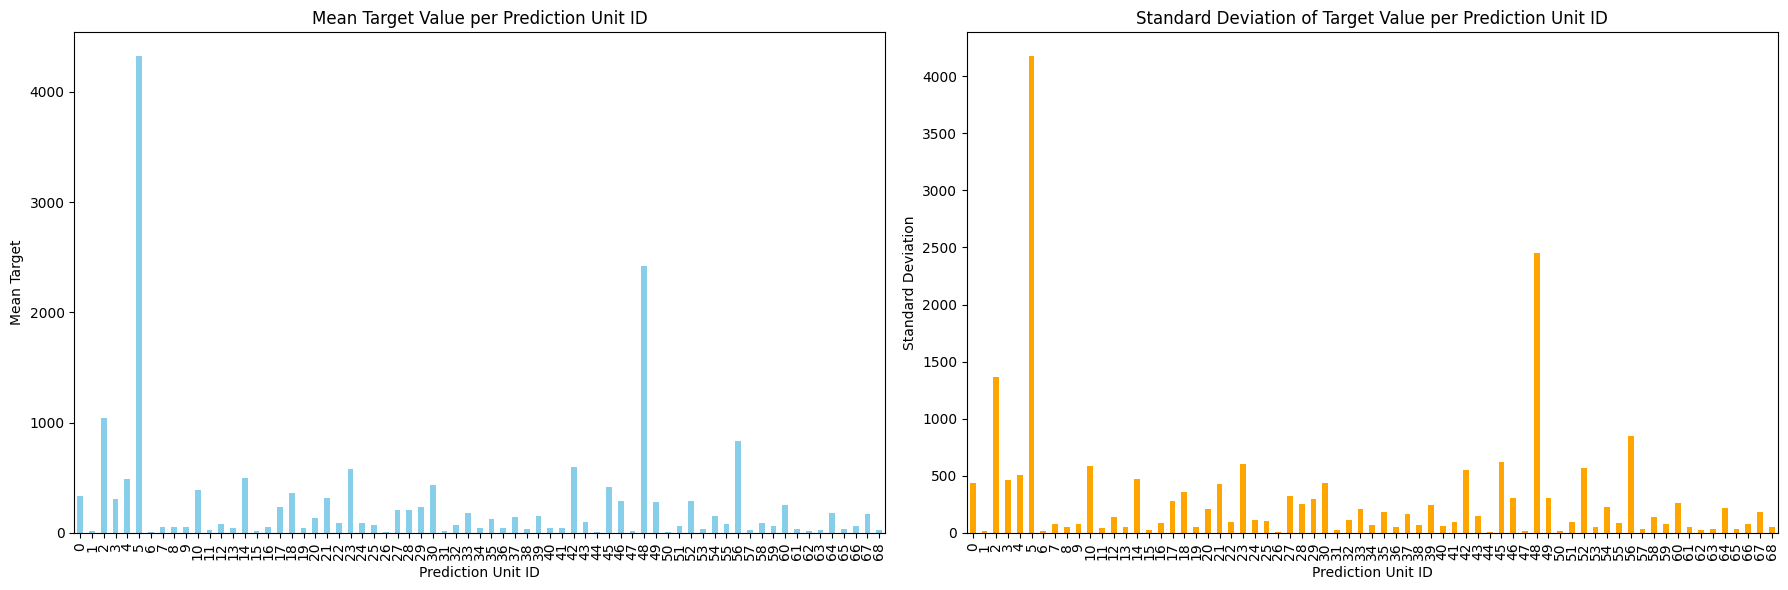

In [21]:
# Create a temporary dataframe grouped by 'prediction_unit_id'
grouped_df = df_train.groupby('prediction_unit_id')

# Calculate the mean and standard deviation of the target for each group
mean_target_per_unit = grouped_df['target'].mean()
std_dev_target_per_unit = grouped_df['target'].std()

# Plot the mean and standard deviation of the target for each prediction unit ID using subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot for mean target value
mean_target_per_unit.plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_title("Mean Target Value per Prediction Unit ID")
axes[0].set_xlabel("Prediction Unit ID")
axes[0].set_ylabel("Mean Target")

# Plot for standard deviation of target value
std_dev_target_per_unit.plot(kind='bar', color='orange', ax=axes[1])
axes[1].set_title("Standard Deviation of Target Value per Prediction Unit ID")
axes[1].set_xlabel("Prediction Unit ID")
axes[1].set_ylabel("Standard Deviation")

plt.tight_layout()
plt.show()


Nhìn vào hình trên, tạm thời có thể thấy ở các `prediction_unit_id` bằng 5 và 48 có dao động lớn hơn hẳn so với các vị trí khác, chúng ta cần phân tích rõ hơn 2 chỗ này là gì mà lại có sự biến động mạnh như vậy. 

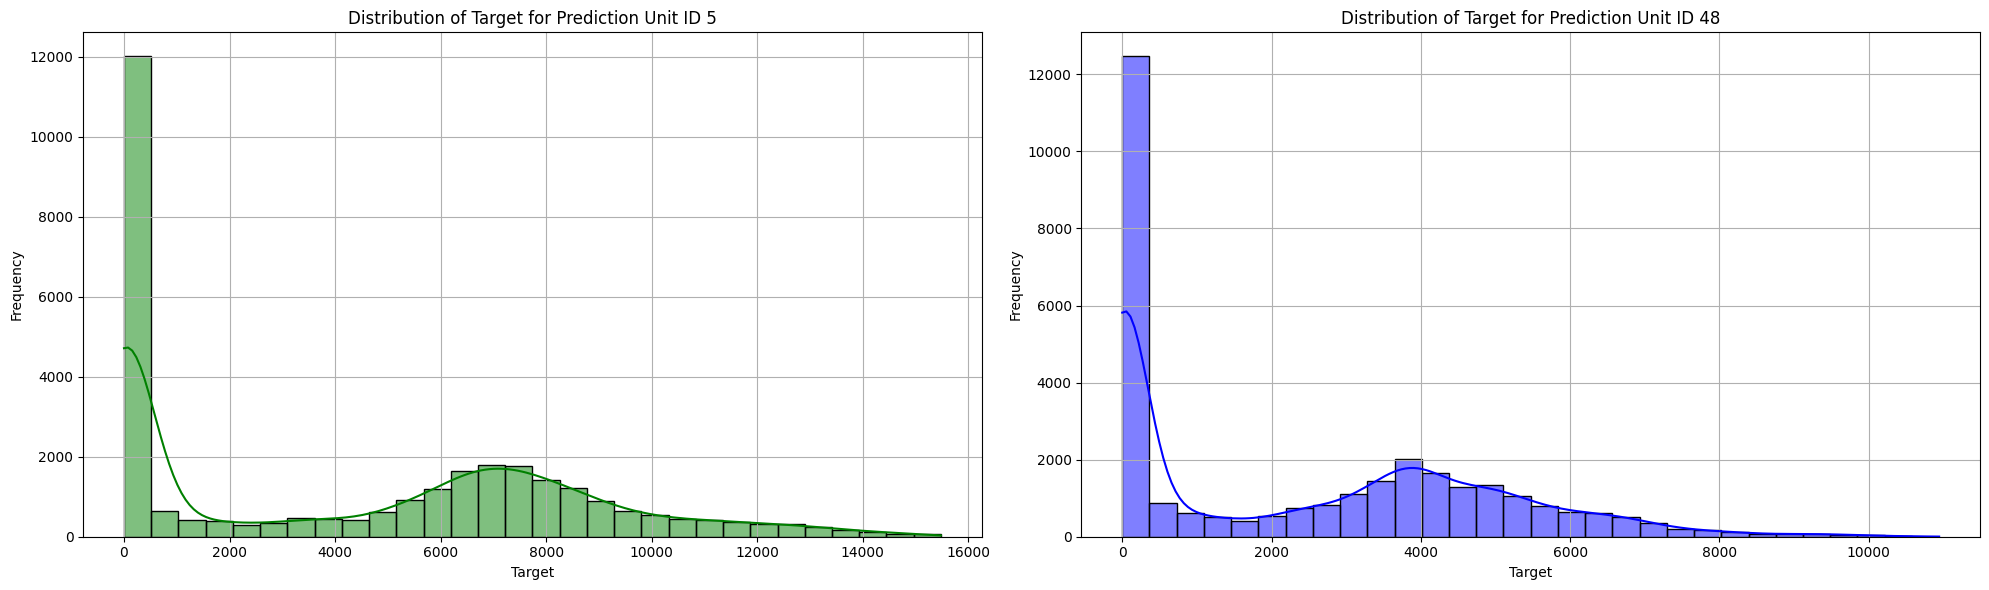

In [23]:
# Filter the dataframe for prediction_unit_id equal to 5 and 48
df_unit_5 = df_train[df_train['prediction_unit_id'] == 5]
df_unit_48 = df_train[df_train['prediction_unit_id'] == 48]

# Plot the distribution of the target variable for prediction_unit_id 5 and 48 using subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plot for prediction_unit_id 5
sns.histplot(df_unit_5['target'], kde=True, bins=30, color='green', ax=axes[0])
axes[0].set_title('Distribution of Target for Prediction Unit ID 5')
axes[0].set_xlabel('Target')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot for prediction_unit_id 48
sns.histplot(df_unit_48['target'], kde=True, bins=30, color='blue', ax=axes[1])
axes[1].set_title('Distribution of Target for Prediction Unit ID 48')
axes[1].set_xlabel('Target')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout()
plt.show()


Không rút ra được kết luận gì từ hình ở trên. 

Ngoài ra, dựa vào dataframe `df_train` ở trên, ta cũng có thể xem xét thêm có bao nhiêu người đang vừa là người tiêu dùng, vừa là người tạo ra năng lượng. 

In [10]:
# Step 1: Identify all prediction_unit_id values where target is 0
prediction_units_with_zero_target = df_train[df_train['target'] == 0]['prediction_unit_id'].unique()

# Step 2: Exclude all rows with these prediction_unit_id values from the dataset
filtered_df = df_train[~df_train['prediction_unit_id'].isin(prediction_units_with_zero_target)]

# Step 3: Count the total number of unique prediction_unit_id in the filtered dataset
total_unique_prediction_unit_id = filtered_df['prediction_unit_id'].nunique()

# Step 4: Count the number of prediction_unit_id where is_consumption is 1 and target is greater than 0
consumption_positive = filtered_df[filtered_df['is_consumption'] == 1]['prediction_unit_id'].nunique()

# Step 5: Count the number of prediction_unit_id where is_consumption is 0 and target is greater than 0
production_positive = filtered_df[filtered_df['is_consumption'] == 0]['prediction_unit_id'].nunique()

print("Total number of unique prediction_unit_id:", total_unique_prediction_unit_id)
print("Number of unique prediction_unit_id where is_consumption == 1 and target > 0:", consumption_positive)
print("Number of unique prediction_unit_id where is_consumption == 0 and target > 0:", production_positive)


Total number of unique prediction_unit_id: 1
Number of unique prediction_unit_id where is_consumption == 1 and target > 0: 1
Number of unique prediction_unit_id where is_consumption == 0 and target > 0: 1


Kế đến là xem xét về phân phối giá trị của target, dựa theo `is_consumption`

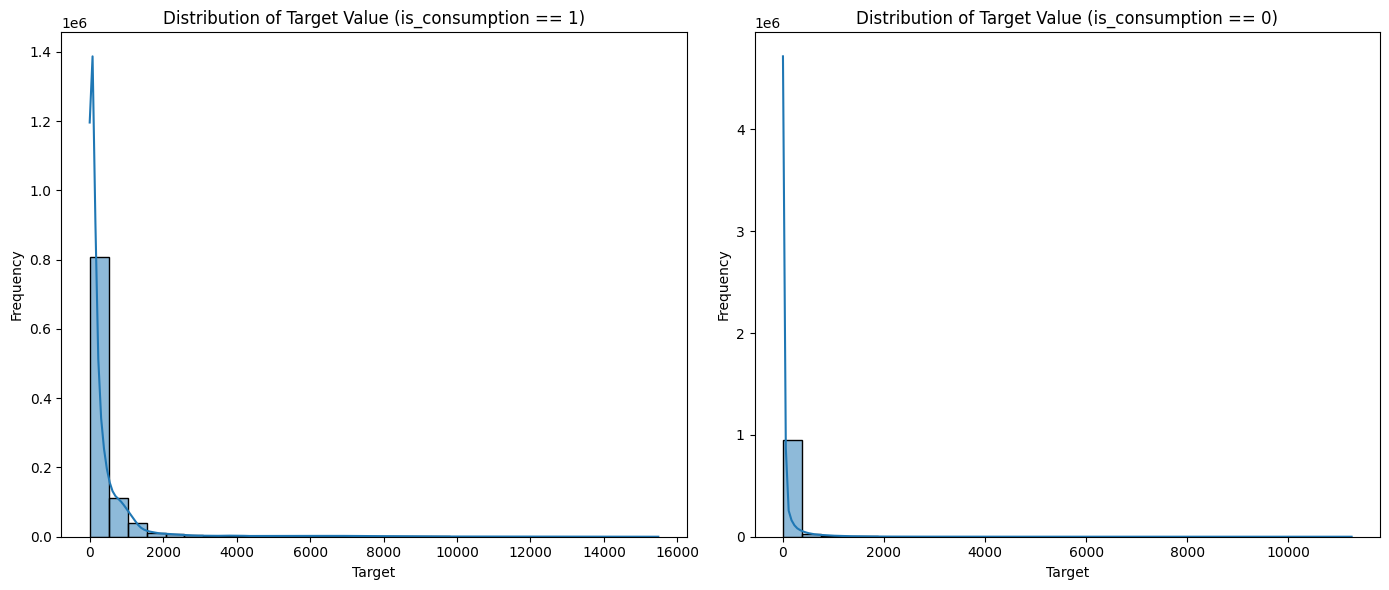

In [11]:
# Filter the data based on is_consumption values
consumption_df = df_train[df_train['is_consumption'] == 1]
production_df = df_train[df_train['is_consumption'] == 0]

# Plot the distribution of the target value for is_consumption == 1
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(consumption_df['target'], kde=True, bins=30)
plt.title('Distribution of Target Value (is_consumption == 1)')
plt.xlabel('Target')
plt.ylabel('Frequency')

# Plot the distribution of the target value for is_consumption == 0
plt.subplot(1, 2, 2)
sns.histplot(production_df['target'], kde=True, bins=30)
plt.title('Distribution of Target Value (is_consumption == 0)')
plt.xlabel('Target')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Để trả lời cho câu hỏi các loại hợp đồng có ảnh hưởng như thế nào đến target, ta có thể vẽ ra phân phối của biến target dựa trên mã trong product type.

Có 4 loại hợp đồng trong trường hợp của bài toán:

- `product_type`: ID của loại hợp đồng, có 4 loại:

    - 0: Combined (Loại hợp đồng kết hợp)
    - 1: Fixed (Loại hợp đồng cố định)
    - 2: General service (Loại hợp đồng dịch vụ)
    - 3: Spot (Loại hợp đồng giao ngay)

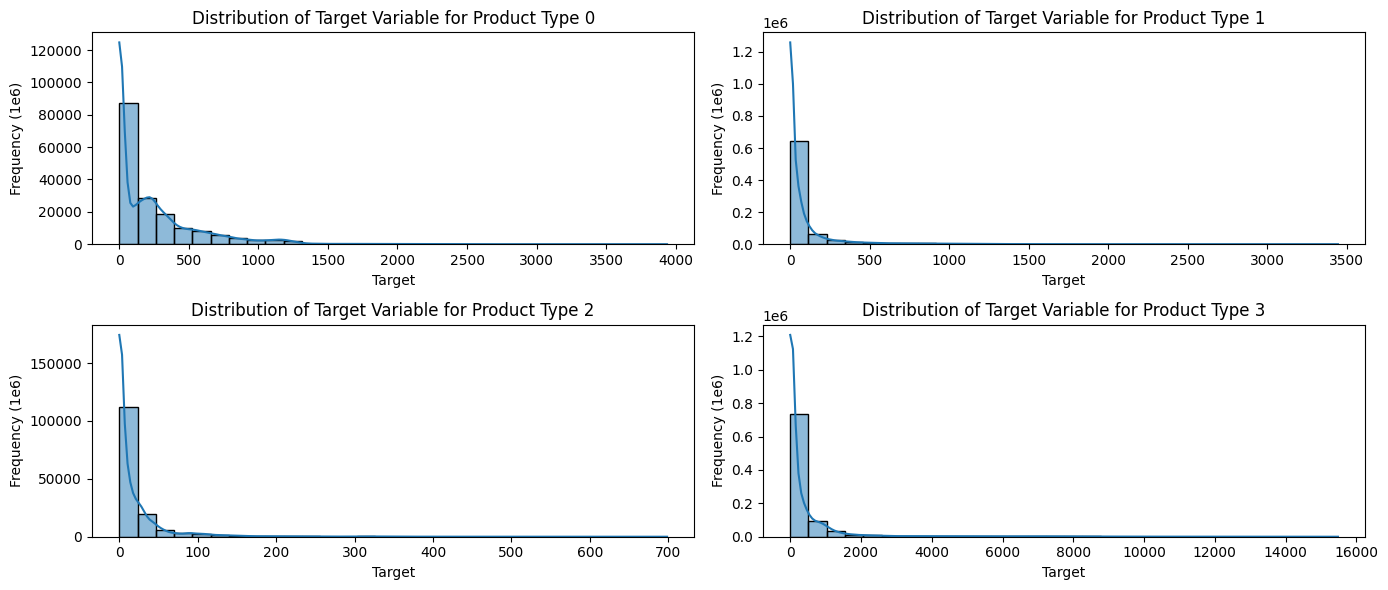

In [15]:
plt.figure(figsize=(14, 6))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df_train[df_train['product_type'] == i]['target'], kde=True, bins=30)
    plt.title(f'Distribution of Target Variable for Product Type {i}')
    plt.xlabel('Target')
    plt.ylabel('Frequency (1e6)')  # Adjusted ylabel to reflect the scale

plt.tight_layout()
plt.show()

Nhìn qua đồ thị ở trên, ta tạm thời rút ra được các kết luận như sau: 

- Đối với **combined contracts (loại 0)**: Năng lượng sử dụng thường thấp, nhưng với cường độ sử dụng cao. 

- Đối với **fixed contracts (loại 1)**: Tương tự như combined contracts, nhưng ít sử dụng/tạo ra nhiều năng lượng hơn so với loại 0.

- Đối với **General Service Contracts (loại 2)**: Là loại có range và peak thấp nhất trong 4 loại hợp đồng, ám chỉ cho việc sử dụng/tạo ra năng lượng ít nhất. 

- Đối với **Spot contracts (loại 3)**: Là loại có tiềm năng tiêu thụ/sản xuất năng lượng cao nhất mặc dù hầu hết các giá trị nằm ở ngưỡng thấp. 

Câu hỏi đặt ra là yếu tố nào dẫn đến việc tiêu thụ/sản xuất điện của hợp đồng loại 3 là cao nhất? 

Có thể thấy hợp đồng loại 3 (loại hợp đồng giao ngay) thường tạo ra/tiêu thụ nhiều năng lượng nhất. Để thấy một cách rõ ràng hơn, ta có thể chuyển sang dạng log cho giá trị target để dễ dàng theo dõi. 

Target+1 là để tránh khỏi việc target bằng 0 làm cho log không xác định. 

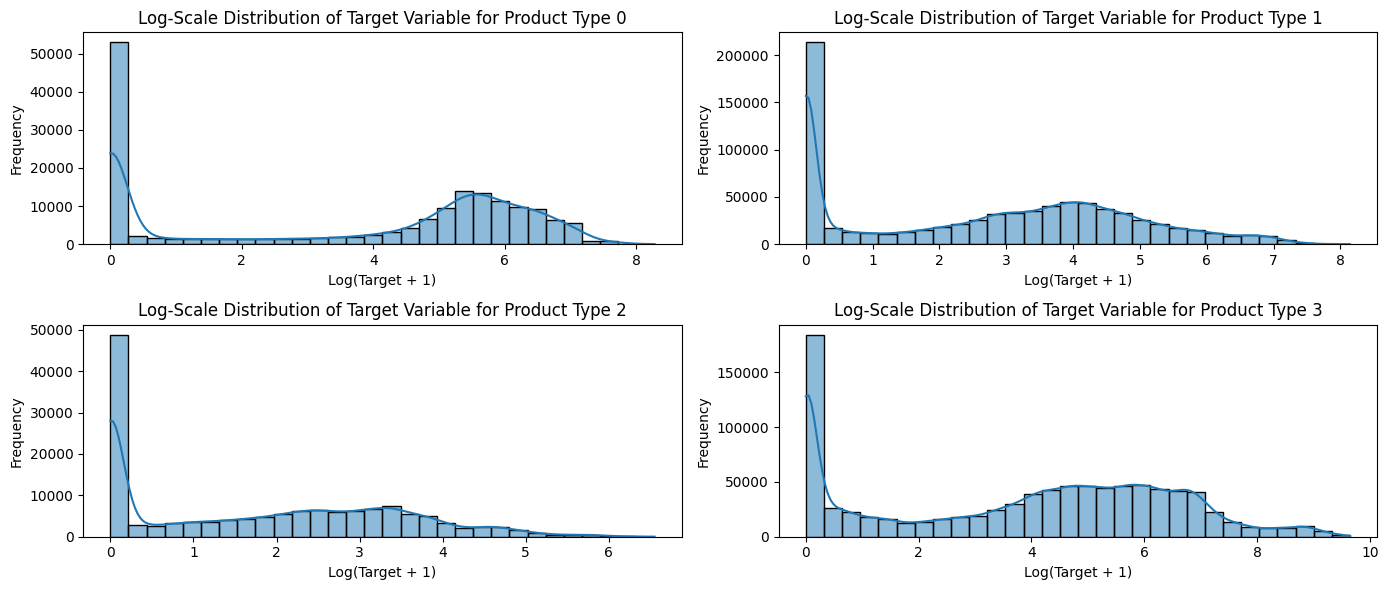

In [17]:
plt.figure(figsize=(14, 6))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    sns.histplot(np.log1p(df_train[df_train['product_type'] == i]['target']), kde=True, bins=30)
    plt.title(f'Log-Scale Distribution of Target Variable for Product Type {i}')
    plt.xlabel('Log(Target + 1)')
    plt.ylabel('Frequency')  # Adjusted ylabel to reflect the scale

plt.tight_layout()
plt.show()

Xác định target lớn nhất

In [30]:
# Select the record with the highest target value
highest_target_record = df_train.loc[df_train['target'].idxmax()]

print(highest_target_record)

county                                  0
is_business                             1
product_type                            3
target                          15480.274
is_consumption                          1
datetime              2022-12-14 11:00:00
row_id                            1481183
prediction_unit_id                      5
Name: 1481183, dtype: object
